In [1]:
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

from utils.loadData import loadDataWithNews
from lstm.preprocessing import dataToTimeSeriesMultiDimensional, getDatasetsMultiDimensional, normalizeAtOnce
from lstm.model import getModel, evaluateModelQuick, evaluateFinal
from lstm.visualization import visualize_loss, show_batch, show_data_simple, showRegressionExampleMultiDimensional, show_heatmap
from lstm.callbacks import es_callback, modelckpt_callback

In [2]:
df = loadDataWithNews()

In [3]:
features = df.loc[:, df.columns != 'Date']
features = features.loc[:, features.columns != 'Unnamed: 0']
features = features.loc[:, features.columns != 'Adj Close']
features.head()

,Open,High,Low,Close,Volume,positive,neutral,negative
0,21308.351563,23642.660156,21234.675781,22805.162109,71378606374,2,3,0
1,22806.796875,23238.601563,22399.812500,23137.960938,40387896275,3,2,0
2,23132.865234,24085.855469,22826.472656,23869.832031,38487546580,0,1,0
3,23861.765625,24209.660156,23147.710938,23477.294922,37844228422,1,2,0
4,23474.455078,24059.982422,22159.367188,22803.082031,45852713981,3,3,0


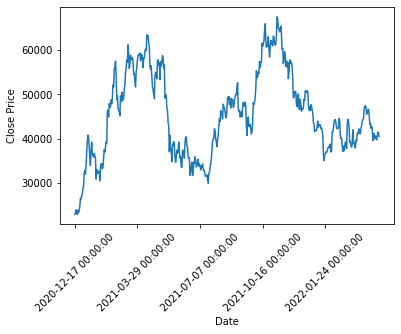

In [4]:
normalized_data, scaler = normalizeAtOnce(features.iloc[:,:-3])
normalized_data = np.concatenate([normalized_data, features.iloc[:,-3:]], axis=1)
show_data_simple(features["Close"], df["Date"])

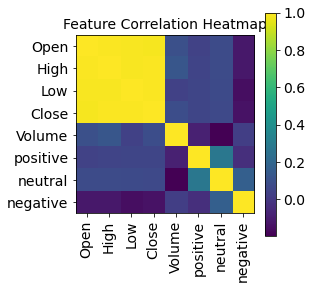

In [5]:
# Data correlation
show_heatmap(features)

In [6]:
# pearson's correlation feature selection for numeric input and numeric output
X = normalized_data[:-1]
y = normalized_data[1:, 3]
# define feature selection
fs = SelectKBest(score_func=f_regression, k=3)
# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected[10])
print(normalized_data[10])

[0.11086992 0.10383976 0.0775005 ]
[0.11096168 0.11086992 0.10383976 0.0775005  0.15640104 1.
 1.         0.        ]


2022-04-22 17:06:09.315461: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


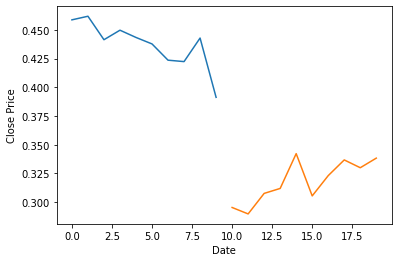

Input shape: (40, 10, 3)
Target shape: (40,)


In [7]:
config = {
    "past": 10,
    "future": 10,
    "neurons": 50,
    "batch_size": 64,
    "epochs": 20,
    "features": X_selected.shape[1]
}

dataset_train, dataset_val, x_test, y_test = getDatasetsMultiDimensional(config, X_selected, 0)


for batch in dataset_val.take(1):
    inputs, targets = batch
    show_batch(inputs[0, :, 0], targets[:config["future"]], config["past"])

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

In [8]:
model = getModel(config)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 3)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 50)            10800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
Total params: 31,510
Trainable params: 31,510
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
6/6 [==============================] - ETA: 0s - loss: 0.2943 - rmse: 0.5425 - mae: 0.4997 - mape: 90.6668
Epoch 1: val_loss improved from inf to 0.09327, saving model to checkpoints/model_checkpoint.h5
6/6 [==============================] - 8s 490ms/step - loss: 0.2943 - rmse: 0.5425 - mae: 0.4997 - mape: 90.6668 - val_loss: 0.0933 - val_rmse: 0.3054 - val_mae: 0.2908 - val_mape: 74.6081
Epoch 2/20
4/6 [===================>..........] - ETA: 0s - loss: 0.1659 - rmse: 0.4073 - mae: 0.3514 - mape: 69.2823
Epoch 2: val_loss improved from 0.09327 to 0.04191, saving model to checkpoints/model_checkpoint.h5
6/6 [==============================] - 0s 73ms/step - loss: 0.1772 - rmse: 0.4209 - mae: 0.3639 - mape: 64.9838 - val_loss: 0.0419 - val_rmse: 0.2047 - val_mae: 0.1662 - val_mape: 42.4460
Epoch 3/20
4/6 [===================>..........] - ETA: 0s - loss: 0.0763 - rmse: 0.2762 - mae: 0.2103 - mape: 42.4334
Epoch 3: val_loss improved from 0.04191 to 0.02634, saving model to check

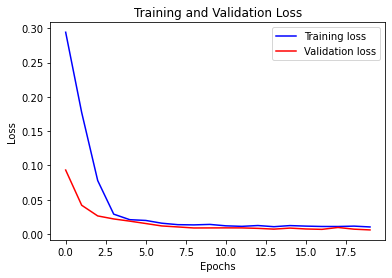

In [9]:
history = model.fit(
    dataset_train,
    epochs=config["epochs"],
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)
visualize_loss(history)

In [10]:
x, y = dataToTimeSeriesMultiDimensional(x_test, y_test[:,0], config["past"], config["future"])

In [11]:
evaluateModelQuick(model, x, y)

1/1 [==============================] - 2s 2s/step - loss: 0.0065 - rmse: 0.0807 - mae: 0.0649 - mape: 14.5968
---- TEST RESULTS ----
MSE loss - 0.006512864492833614
RMSE - 0.08070231974124908


In [12]:
evaluateFinal(getModel, dataset_train, dataset_val, config, "regression_with_news_features_chosen")

Training Started...
Iterations:
1
2
3
4
5
6
7
8
9
10
Done
